# Importing all python Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
# Load original scaler
from sklearn.preprocessing import MinMaxScaler
import joblib
import random
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

## Setting Random Seeds for Reproducibility

In [2]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preprocessing and Preparation

#### Data Loading, Scaling, Sequence Generation, and Tensor Preparation


In [3]:
os.makedirs("model", exist_ok=True)
# === Data Loading ===
df = pd.read_csv("../dataset/apple.csv")
df = df[["Open", "High", "Low", "Close", "Volume"]].apply(pd.to_numeric, errors="coerce").dropna()
feature_cols = ["Open", "High", "Low", "Volume"]
target_col = ["Close"]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df[feature_cols])
y_scaled = target_scaler.fit_transform(df[target_col])

# === Sequence Preparation ===
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

seq_length = 20
X, y = create_sequences(X_scaled, y_scaled, seq_length)

# === Train/Val/Test Split ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.4, shuffle=False)

# === Convert to Tensor ===
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# === Save Tensors ===
torch.save(X_test_tensor, "model/X_test_tensor.pt")
torch.save(y_test_tensor, "model/y_test_tensor.pt")

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=True)


# LSTM Architecture and setup 
### (Same archtitecture followed in QLSTM)

In [4]:
class ClassicalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 4)  
        self.fc2 = nn.Linear(4,1)            
        self.fc3 = nn.Linear(1, 1)            

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        out = self.fc3(out)   
        return out


# === Initialize Model ===
model = ClassicalLSTM(input_size=4, hidden_size=16)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001 ,alpha=0.9, eps=1e-8, momentum=0.9, weight_decay=1e-5)
loss_fn = nn.MSELoss()


## Train LSTM Model with Early Stopping

In [5]:
epochs = 300
patience = 10
best_val_loss = float('inf')
counter = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            preds_val = model(xb_val)
            val_loss = loss_fn(preds_val, yb_val)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "model/best_classical_model.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/300 - Train Loss: 0.3647 - Val Loss: 0.0094
Epoch 2/300 - Train Loss: 0.0462 - Val Loss: 0.0896
Epoch 3/300 - Train Loss: 0.0324 - Val Loss: 0.0827
Epoch 4/300 - Train Loss: 0.0319 - Val Loss: 0.0617
Epoch 5/300 - Train Loss: 0.0314 - Val Loss: 0.0742
Epoch 6/300 - Train Loss: 0.0336 - Val Loss: 0.0543
Epoch 7/300 - Train Loss: 0.0131 - Val Loss: 0.0204
Epoch 8/300 - Train Loss: 0.0012 - Val Loss: 0.0009
Epoch 9/300 - Train Loss: 0.0003 - Val Loss: 0.0012
Epoch 10/300 - Train Loss: 0.0003 - Val Loss: 0.0005
Epoch 11/300 - Train Loss: 0.0003 - Val Loss: 0.0004
Epoch 12/300 - Train Loss: 0.0003 - Val Loss: 0.0005
Epoch 13/300 - Train Loss: 0.0002 - Val Loss: 0.0004
Epoch 14/300 - Train Loss: 0.0003 - Val Loss: 0.0008
Epoch 15/300 - Train Loss: 0.0003 - Val Loss: 0.0004
Epoch 16/300 - Train Loss: 0.0002 - Val Loss: 0.0005
Epoch 17/300 - Train Loss: 0.0003 - Val Loss: 0.0009
Epoch 18/300 - Train Loss: 0.0003 - Val Loss: 0.0007
Epoch 19/300 - Train Loss: 0.0002 - Val Loss: 0.0006
Ep

## Make Predictions with Trained LSTM Model


In [6]:
model.load_state_dict(torch.load("model/best_classical_model.pt"))
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).detach().numpy()

y_pred_inv = target_scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_inv = target_scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

## Compute Regression Metrics

In [7]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
explained_variance_scoree = explained_variance_score(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f} RMSE: {rmse:.4f}, Explained Variance: {explained_variance_scoree:.4f}")

MSE: 242.2885, MAE: 13.2594, R2: 0.5244 RMSE: 15.5656, Explained Variance: 0.8350


#  Plot (Actual vs Predicted)

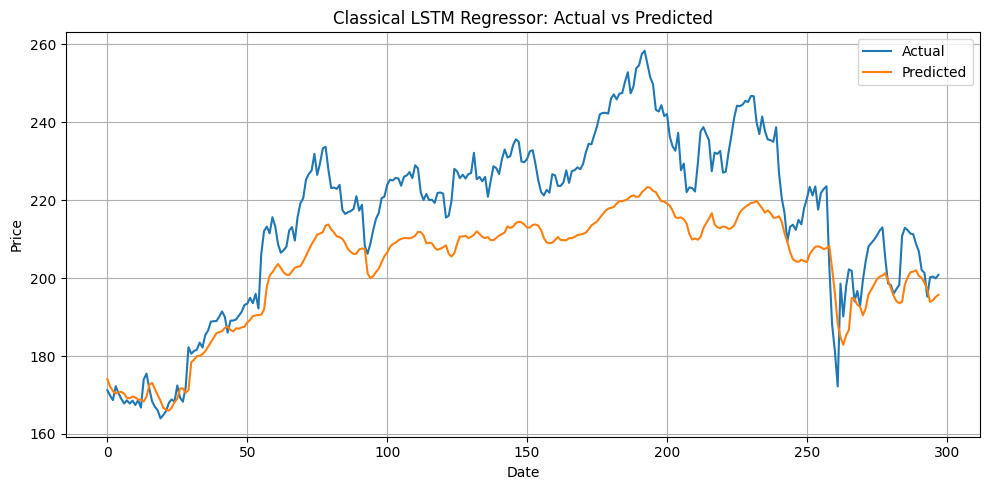

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title("Classical LSTM Regressor: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

# Plot Loss Curves

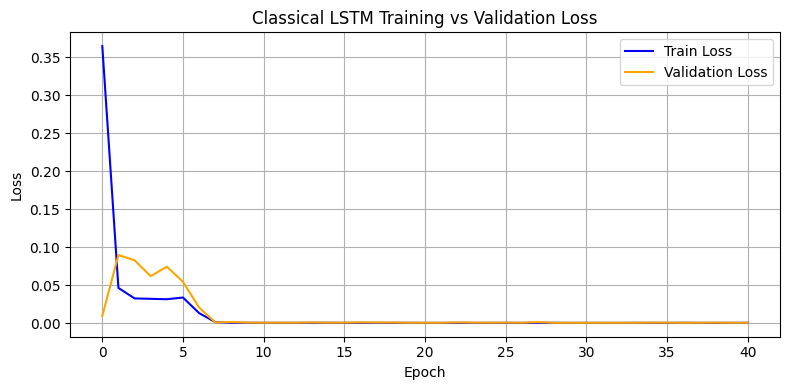

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classical LSTM Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()